# Tutorial

In this tutorial, we demonstrate how summit can be used to optimize reactions automatically. 


Summit introduces two key concepts: **benchmarks** and **strategies**. Benchmarks are simualations of reactions, and strategies are ML algorithms used to choose experiments. Two benchmarks are already implemented, and it is easy to add more. We are going to optimise a nucleophilic aromatic substitution (SnAr) benchmark.

Summit provides access to six different optimisation strategies. And, it gives a common interface, so you can easily switch between strategies. We'll see that soon.


## SnAr Benchmark


![](_static/hone_2016_snar_chemistry.png)

Nucleophilic aromatic substitution reactions are commonly used in the fine chemicals industry. <!--Something about their frequncy from the Journal of medicinal chemistry letters paper --> In this case, 2,4 dinitrofluorobenzene (**1**) undergoes nucleophilic attack by pyrrolidine (**2**) to form the desired product **3**. Two side products **4** and **5** can also be formed. Overall, we want to maximize the amount of product formed and minimze side product formation and waste.

The kinetics of this reaction were published by [Hone et al.](http://xlink.rsc.org/?DOI=C6RE00109B) We imagine a scenario where this reaction is to be optimized in a flow reactor. We have set up a "virtual" flow chemistry reactor in the `SnarBenchmark` using the published kinetics and standard chemical engineering equations. You simply supply the reaction conditions to `SnarBenchmark` and it will give back the results of a virtual experiment with those conditions. Think of it as your virtual laboratory.

Below, we start importing the needed packages and setting up the virtual lab.

In [1]:
from summit.benchmarks import SnarBenchmark
from summit.utils.dataset import DataSet

In [2]:
lab = SnarBenchmark()
lab.domain

We print out the `domain` which describes the optimization problem associated with `SnarBenchmark`.  The objectives are to maximize space-time yield (STY) and minimize E-factor. STY is the mass of product produced per reactor volume per time, and E-factor is the ratio of the mass of waste to mass of product. Waste is the amount of side product produced (**4** and **5**), unreacted starting material and solvent in the reactor outlet stream. By minimizing E-factor, we are effectively maximizing selectivity and reaction "greeness" at the same time. 

We optimize the reactions by changing the residence time, inlet concentration of 2,4-dinitrofluorobenzene (**1**), equivalences of of pyrrolidine (**2**), and temperature. 

### Running a single experiment

Before we do any optimization, let's get a sense of how our virtual laboratory works. Below, we run one virtual experiment with relatively mild conditions (residence time = 0.5 minutes, equiv of **2** = 1.5, concentration of **1** = 0.1 M and T = 30.0Â°C).

In [3]:
# Create some test conditions
columns = [v.name for v in lab.domain.variables]
values  =   {('tau', 'DATA'): 1.5,  # minutes
             ('equiv_pldn', 'DATA'): 0.5,  
             ('conc_dfnb', 'DATA'): 0.1, #molar
             ('temperature', 'DATA'): 30.0, # degrees celsius
              }
conditions = DataSet([values], columns=columns)

# Run the conditions
lab.reset()
results = lab.run_experiments(conditions)
results

NAME  tau equiv_pldn conc_dfnb temperature         sty    e_factor  \
TYPE DATA       DATA      DATA        DATA        DATA        DATA   
0     1.5        0.5       0.1        30.0  168.958672  191.260294   

NAME computation_t experiment_t strategy  
TYPE      METADATA     METADATA METADATA  
0              0.0     0.007143      NaN

In the above code, we put our reaction conditions in a summit DataSet, which is a Pandas dataframe that allows us to specify certain columns as metadata. For example, the experiment time column is a metadata column. That's why the values dictionary has tuples that specify the type of columns (DATA vs. METADATA).  

We run the virtual experiment using `lab.run_experiments`, which integrates the kinetic equations at the conditions given. The results are printed out.

We can see that these conditions give a very low space-time yield (a good value would be around >10,000 kg/m^3/h) and high E-factor (a good value would be <10).  So, let's try to optimze the conditions. 

### Random Strategy

In Summit, methods for optimizing reactions are called strategies. There are six strategies available, each with different capabilities. The advantage of using Summit is that we can quickly and easily test out different strategies on a problem to see which one performs best. 

We are going to first use a random strategy as a baseline, where each experiment is selected at random. Any advanced strategies should at least perform better than this.

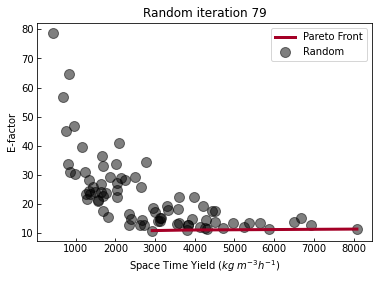

In [4]:
from summit.benchmarks import SnarBenchmark
from summit.strategies import Random
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Set up the laboratory
lab = SnarBenchmark()
lab.reset()

# Instantiate random sampling strategy
random = Random(lab.domain)
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']

# Run random sampling
print("Running Random sampling")
for i in range(80):
    
    # Get Random suggestions
    experiments = random.suggest_experiments(1)
    
    # Run experiments
    results = lab.run_experiments(experiments)

    # Update plot every 5 iterations
    if i % 5 == 0:
        clear_output(wait=True)
        fig, ax = lab.pareto_plot()
        ax.set_xlabel(names[0])
        ax.set_ylabel(names[1])
 
        ax.tick_params(direction='in')
        plt.show(fig)
        print(f"Running random iterations {i+1} to {i+5}")

clear_output(wait=True)
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_title(f"Random iteration {i}")
ax.tick_params(direction='in')
plt.show(fig)

In the above code, we start by creating the laboratory as we did before. We then setup the random strategy using `Random`and ask it for experiments using `suggest_experiments`. We run those experiments and plot the results. 

The above plot is a pareto plot. Each point in the above plot represents the objective values for a different set of reaction conditons. The pareto front shows the conditions that optimize space-time yield at the cost of E-factor and vice versa. 

### TSEMO Strategy

TSEMO is a multiobjective optimization strategy, meaning that it can find the tradeoffs between two competing objectives. Below, is all the code needed to run TSEMO. Note that running this code will take a few minutes.

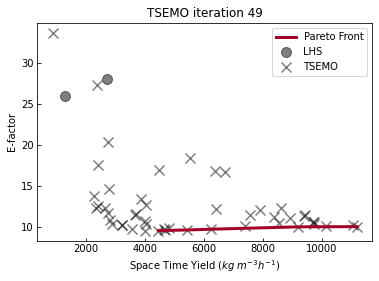

In [12]:
from summit.benchmarks import SnarBenchmark
from summit.strategies import TSEMO
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

#Set up the laboratory
lab = SnarBenchmark()
lab.reset()

# Set up the TSEMO strategy
tsemo = TSEMO(lab.domain, n_spectral_samples=1500)
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']

# Plot initial experiments
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
plt.show(fig)

# Run TSEMO
print("Running TSEMO")
results=None
for i in range(50):    
    # Get TSEMO suggestions
    experiments = tsemo.suggest_experiments(1, prev_res=results)
    
    # Run experiments
    results = lab.run_experiments(experiments)

    # Update plot every 5 iterations
    if i % 5 == 0:
        clear_output(wait=True) # Clear the previous plot
        fig, ax = lab.pareto_plot()
        ax.set_xlabel(names[0])
        ax.set_ylabel(names[1])
        ax.set_title(f"TSEMO iteration {i}")
        ax.set_yscale('log')
        ax.tick_params(direction='in')
        plt.show(fig)
        print(f"Running TSEMO iteration {i+1}")

# Make final plot
clear_output(wait=True)
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_title(f"TSEMO iteration {i}")
ax.tick_params(direction='in')
plt.show(fig)

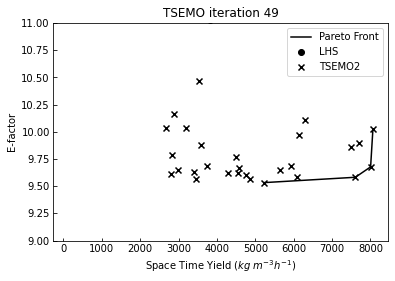

In [6]:
# Just showing the pareto front
clear_output(wait=True)
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_title(f"TSEMO iteration {i}")
ax.set_ylim(9, 11)
ax.tick_params(direction='in')
plt.show(fig)

The code above is very similar to the random sampling code with some minor changes. We start by asking TSEMO for 30 experiments. Since we don't pass any previous results, it will use latin hypercube sampling, which is a space-filling random sampling technique, to get initial experiments. As shown in the above plot, the points choosen are quite random and give a good sampling of the space.

Then, we run TSEMO in earnest for 50 more iterations, asking for one experiment each time. Note that we transform the objectives into log space, since this has been shown to improve the performance of optimization algorithms. 

As we ask for more experiments, we better see the pareto front, which represents the trade off between space-time yield and E-factor. We show the pareto front more clearly below. In the second plot, its clear how TSEMO chooses many more optimal or near optimal points than random sampling.

Below we print out the pareto front conditions for the SnAr reaction.

In [250]:
from summit.utils.multiobjective import pareto_efficient

objectives = [v.name for v in lab.domain.variables
              if v.is_objective]
data = lab.data[objectives].copy()

#Handle minimize objectives
for objective in objectives:
    if not lab.domain[objective].maximize:
        data[objective] = -1.0*data[objective]

values, indices = pareto_efficient(data.to_numpy(),
                                   maximize=True)

pareto_data = lab.data.iloc[indices]
pareto_data

NAME       tau  equiv_pldn  conc_dfnb  temperature          sty  e_factor  \
388   0.846752    1.817991   0.494767    47.544955  6663.547974  9.784374   
713   1.605081    1.293420   0.498311    69.999020  3535.282155  9.553033   
867   0.845041    1.296763   0.488834    84.814663  6564.653961  9.745980   
274   0.864869    1.324289   0.496886    92.616767  6466.718639  9.705964   
749   0.774055    1.353482   0.488045    87.629348  7135.611494  9.812046   
876   0.901703    1.131961   0.499655    93.398575  6236.145167  9.572239   
112   1.854376    1.141609   0.499815    74.038180  3063.583040  9.480495   
862   1.223413    1.281558   0.499545    79.013165  4636.978563  9.553696   

NAME  computation_time  experiment_time strategy  
388           4.712905         0.004277   TSEMO2  
713           3.900388         0.004382   TSEMO2  
867           4.398601         0.003978   TSEMO2  
274           4.014828         0.004296   TSEMO2  
749           4.073402         0.004100   TSEMO2  
876           6.082278         0.007380   TSEMO2  
112           6.756613         0.004294   TSEMO2  
862           6.201299         0.006104   TSEMO2

## Runner

### Running Experiments Externally

Running experiments externally is the most common use of summit. There is a simple set of commands that allows you to do this. Let's say we are going to run the SnarBenchmark ourselves instead of in a closed-loop setup. We'll use TSEMO since this is a multiobjective problem.

In [14]:
# Import the necessary classes
from summit.benchmarks import SnarBenchmark
from summit.strategies import TSEMO2
from summit.utils.dataset import DataSet

In [15]:
# We are just going to get the domain from the SnarBenchmark
exp = SnarBenchmark()

# Instatiate TSEMO
tsemo = TSEMO2(exp.domain)

# To get the first experiments
next_experiments = tsemo.suggest_experiments(5)
next_experiments

NAME   tau  equiv_pldn  conc_dfnb  temperature strategy
0     0.65         2.2       0.46         75.0      LHS
1     0.95         3.0       0.38        111.0      LHS
2     1.25         4.6       0.14         57.0      LHS
3     1.85         3.8       0.30         39.0      LHS
4     1.55         1.4       0.22         93.0      LHS

You'll notice that the first set of experiments was generated by LHS or latin hypercube sampling. We'll need to go to the lab and run experiments at those conditions. 

Since it might be a while before we come back, let's save what we've done up until now. We save a file called `snar_tsemo_external.json` which contains all of the information we need to reproduce our work up to this point.  We will also produce a CSV with the suggested conditions, which we can use to record the results of our experiments. 

In [16]:
# Save TSEMO hyperparameters and internal state
tsemo.save('assets/snar_tsemo_external.json')
# Save experiments to CSV
next_experiments.to_csv('assets/snar_experiments_external_0.csv')

Normally, we would now go and run the experiments separately and add a column for sty and yield with our results. We could do that in Excel. However, since this is just a demonstration, we'll simulate the experiments using the SnarBenchmark class and save the results to a CSV. 

In [17]:
# "Run" the experiments and save to CSV.
results = exp.run_experiments(next_experiments)
results.to_csv('assets/snar_experiments_external_1.csv')

Now that we have run the conditions, we can load TSEMO and the data back in from the files we saved.

In [24]:
# Load in previous TSEMO hyperparameters and internal state
tsemo = TSEMO2.load('assets/snar_tsemo_external.json')

# Load in experimental results
prev_res = DataSet.read_csv('assets/snar_experiments_external_1.csv')
prev_res

NAME   tau equiv_pldn conc_dfnb temperature      sty e_factor computation_t  \
0     0.65        2.2      0.46          75  7786.66   10.987             0   
1     0.95          3      0.38         111  2887.74  20.6038             0   
2     1.25        4.6      0.14          57  1249.55  32.8315             0   
3     1.85        3.8       0.3          39  1796.91  16.4831             0   
4     1.55        1.4      0.22          93  1595.83  20.4113             0   

NAME experiment_t strategy  
0       0.0123229      LHS  
1        0.011729      LHS  
2      0.00975466      LHS  
3       0.0111432      LHS  
4      0.00985384      LHS

Now, we can run TSEMO again and ask for new suggested conditions based on the first set of experiments.

In [26]:
# Get experimental suggestions from TSEMO
second_experiments = tsemo.suggest_experiments(5, prev_res=prev_res)

# Save TSEMO state
tsemo.save('assets/snar_tsemo_external_2.json')

# Save experiments to CSV
second_experiments.to_csv('assets/snar_experiments_external_2.csv')
second_experiments

NAME       tau  equiv_pldn  conc_dfnb  temperature          sty   e_factor  \
418   0.503062    2.159430   0.333136    39.349317  8571.641870  20.263332   
417   1.942759    2.438533   0.218445    40.658336  1900.742195  20.262234   
340   0.937271    2.522983   0.455450   102.966221  3068.119187  20.300237   
896   1.273378    4.840805   0.212085    68.186840  1260.200774  21.023510   
506   0.915507    3.835045   0.486018   109.584684  3397.920469  20.275177   

NAME strategy  
418    TSEMO2  
417    TSEMO2  
340    TSEMO2  
896    TSEMO2  
506    TSEMO2

We can repeat the the cycle of saving and loading the TSEMO paramters and next experiments until we are satisfied with the results.

### Running Closed Loop Experiments

Summit has special functionality for running closed-loop experiments.  The runner class takes a strategy and experiment. It then get experiment suggestions from the strategy and runs the experiments.

Note that in order to see the progress bar in jupyter, you'll need to install the jupyter or jupyterlab extension for ipywidgets. See [here](https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-the-jupyterlab-extension) for details.

In [5]:
# Import the necessary classes
from summit.benchmarks import Hartmann3D
from summit.strategies import SNOBFIT, NelderMead
from summit.utils.dataset import DataSet
from summit.run import Runner

In [36]:
# Establish the experiment. Here, we are using one of the single objective test functions
exp = Hartmann3D(maximize=True, constraints=False)

# Set up the strategy, passing in the experimental domain.
nm = NelderMead(exp.domain)

# Use the runner to run closed loop experiments
r = Runner(strategy=nm, experiment=exp, 
           max_iterations=5)
r.run()

We can also save and load the state of the runner to disk.

In [47]:
# Save everything to a file
r.save('assets/snobfit_hartmann.json')

# Load everything from a file
Runner.load('assets/snobfit_hartmann.json')

# Transforms
Transforms can be used to change the representation of a particular domain to match the needs of a particular strategy. For example, there is a MultitoSingleObjective transform that converts multiobjective problems to single objectives problems. This makes multiobjective problems solvable by single objective strategies (e.g., SNOBFIT).

In [6]:
from summit.benchmarks import SnarBenchmark
from summit.strategies import (TSEMO2, SNOBFIT, Transform, 
                               LogSpaceObjectives, MultitoSingleObjective)
from summit.utils.dataset import DataSet
from summit.utils.multiobjective import pareto_efficient, HvI
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [7]:
lab = SnarBenchmark()
lab.domain

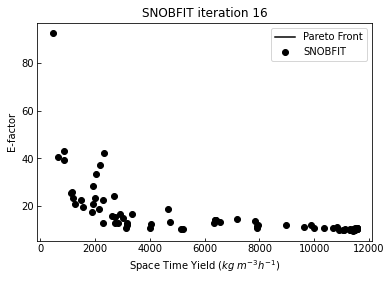

In [8]:
lab.reset()

# Set up the SNOBFIT strategy
transform = MultitoSingleObjective(lab.domain, 
                                   expression='-sty/1e4+e_factor/100', 
                                   maximize=False)
snobfit = SNOBFIT(lab.domain, transform=transform)

names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']
results= None
prev_param = None

# Run SNOBFIT
print("Running SNOBFIT iteration 1")
for i in range(16):
    # Get SNOBFIT suggestions
    experiments, _, _, prev_param = snobfit.suggest_experiments(5, 
                                                               prev_res=results,
                                                               prev_param=prev_param)
    
    # Run experiments
    results = lab.run_experiments(experiments)
    
    clear_output(wait=True) # Clear the previous plot
    fig, ax = lab.pareto_plot()
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])
    ax.set_title(f"SNOBFIT iteration {i+1}")
    ax.set_yscale('log')
    ax.tick_params(direction='in')
    plt.show(fig)
    print(f"Running SNOBFIT iteration {i+2}")
    

# Make final plot
clear_output(wait=True)
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_title(f"SNOBFIT iteration {i+1}")
ax.tick_params(direction='in')
plt.show(fig)

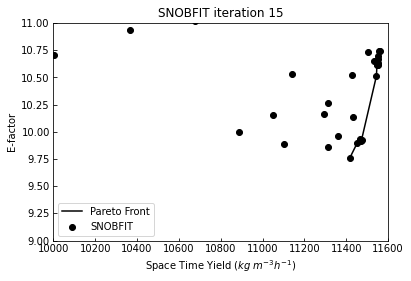

In [9]:
# Just showing the pareto front
clear_output(wait=True)
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_title(f"SNOBFIT iteration {i}")
ax.set_ylim(9, 11)
ax.set_xlim(1e4, 1.16e4)
ax.tick_params(direction='in')
plt.show(fig)